# Movie Data Analysis

## Overview

Our project involves the examination of film data sourced from the Internet Movie Database (IMDb), the Numbers database (TN), and The Movie Database (TMDB). By analyzing a film's worldwide gross, budgets, genres, ratings, and directors, we hope to gain insights that will guide decision-making within the film industry. Our aim is to evaluate trends in these specific categories associated with film success. Through this comprehensive analysis, we will be able to make recommendations leading to a successful production.

## Business Problem

Now that we've successfully taken over the aviation industry, it's time to expand our company, newly renamed to AirFlix Studios, to the next frontier: film. This will allow our company to grow while also providing our passengers with top of the line entertainment during their flights. 

To facilitate this transition, we focused on three ways AirFlix can start out ahead in this industry. First, we want to focus on Worldwide success. We want to utilize the world's boundless market and focus on films that can be enjoyed not just in the States, but abroad as well. Second, we want to create blockbuster films. We want movies that draw wide-ranging audiences with all different tastes and preferences. And finally, we want to build brand recognition. We want the public to associate our name with high-quality films. We want people lining up at the theatre just because they saw our name in the trailer.

In order to accomplish all three of those, our data analysis led to the following recommendations:
1. Worldwide Success ----> Big Budgets
2. Blockbuster Films ----> Adventurous, Musical Animations
3. Brand Recognition ----> High-Quality Directors

Continue below to see how we arrived at these recommendations.

## Data Understanding

The datasets used in this analysis come from the Internet Movie Database (IMDb), the Numbers database (TN), and The Movie Database (TMDB).

For Budget, we focused on over 2,000 movies from The Numbers and The Movie Database to find correlations between budget and worldwide gross.

For Genre and Director, we used the IMDb data and honed in on those blockbuster films by removing movies with less than 10,000 votes for their rating. The reason for this was that we saw films under this threshold as not having substantial Worldwide Gross numbers. 

For Director analysis, we created a director rating by averaging the IMDb's movie ratings for every movie that director worked on. We focused on about 70 experienced Directors that have at least 3 films and a rating of at least 7.0. 

In [1]:
#Imports
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import pickle
import os
from statsmodels.formula.api import ols

### IMDB

In [2]:
im_db = 'data/im.db'

im_db_conn = sqlite3.connect(im_db)

q = """

SELECT *
FROM sqlite_master


;
"""

pd.read_sql(q, im_db_conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


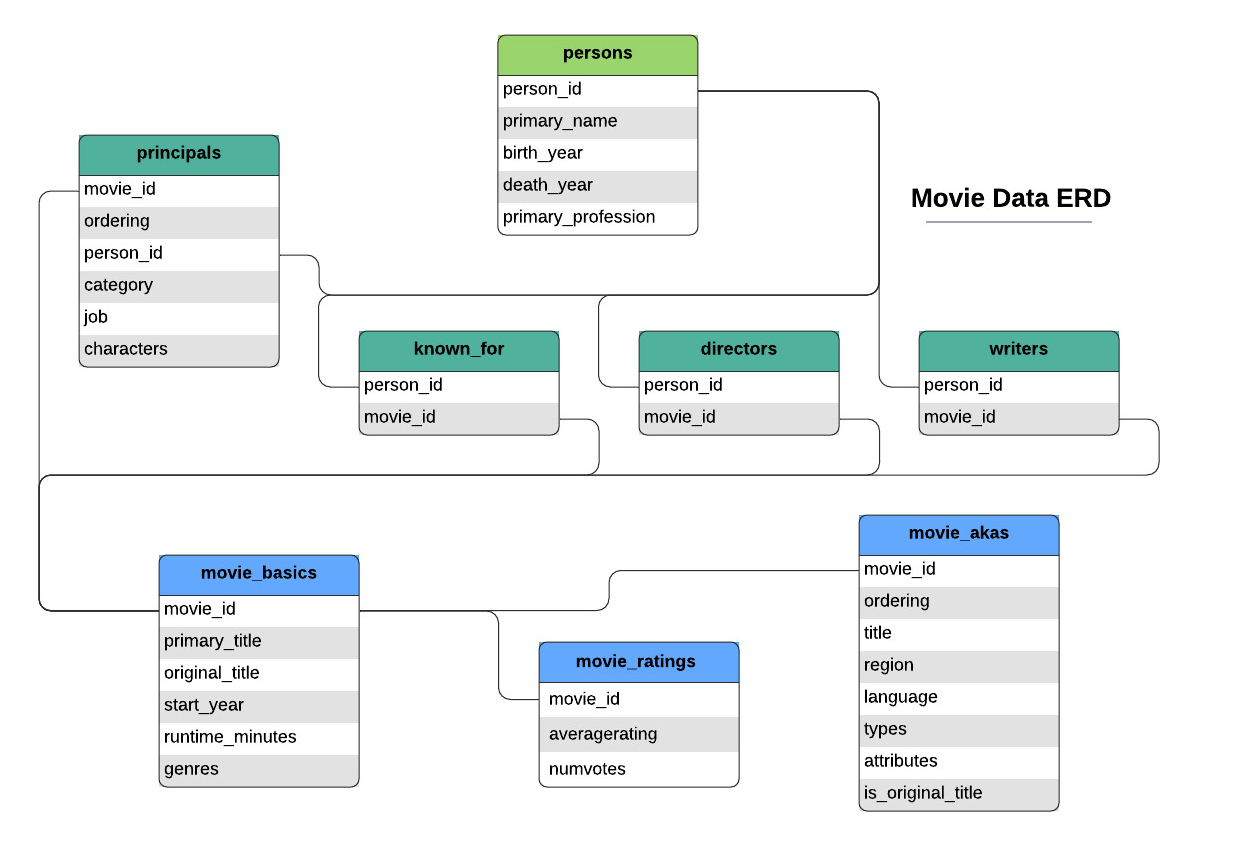

According to the IMDb Movie Data ERD, we decided that the known_for, movie_akas, and principals tables would not be needed for the analysis of budget, genre, and director.

In [3]:
q = """

SELECT *
FROM movie_basics

;
"""

pd.read_sql(q, im_db_conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [4]:
q = """

SELECT *
FROM movie_ratings

;
"""

pd.read_sql(q, im_db_conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


We noticed there was a large discrepancy in the number of votes. This would need to be investigated further to determine validity of each film's rating.

In [5]:
q = """

SELECT *
FROM persons

;
"""

pd.read_sql(q, im_db_conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


We noticed that this table would be useful in tying in director names to other tables to run analysis on directors.

In [6]:
q = """

SELECT *
FROM directors

;
"""

pd.read_sql(q, im_db_conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


This table would be used to associate directors with their films.

In [7]:
q = """

SELECT *
FROM writers

;
"""

pd.read_sql(q, im_db_conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
...,...,...
255868,tt8999892,nm10122246
255869,tt8999974,nm10122357
255870,tt9001390,nm6711477
255871,tt9004986,nm4993825


This table would be used to associate writers with their films.

### TMDB Movies

In [8]:
movies_df = pd.read_csv("data/tmdb.movies.csv")
movies_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [9]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


From the movies_df we noticed that the release_date would need to be converted to date time so that we could run an analysis on that column.

### TN Movie Budgets

In [10]:
budgets_df = pd.read_csv("data/tn.movie_budgets.csv")
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [11]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


From the budgets_df we noticed that the release_date would need to be converted to date time and the production_budget, domestic_gross, and worldwide_gross would need to be converted to numerics so that we could run an analysis on those columns.

## Data Preparation

To focus on Genre and Director, we consolidated the IMDb data by joining the movie_basics, directors, movie_ratings, and persons tables. To focus on wide-spread blockbuster films, we removed movies with less than 10,000 votes for their rating. We decided on 10,000 votes because further research online found that movies with less than 10,000 votes had very low gross, and we wanted to focus on films with a wider audience.

In [12]:
#Join movie_basics, directors, movie_ratings, and persons with filter to only include films with 10k votes or more
q = """

SELECT DISTINCT *
FROM movie_basics
LEFT JOIN directors
    USING(movie_id)
LEFT JOIN movie_ratings
    USING(movie_id)
LEFT JOIN persons
    USING(person_id)
WHERE numvotes > 9999 and averagerating != 'NaN'
;
"""

cleaned_movies_df = pd.read_sql(q, im_db_conn)

In order to recommend directors, we calculated each director's average rating. Each director's score was calculated by averaging the IMDb movie ratings for each film they created. 

In [13]:
#Create series with each director's rating by averaging the films' ratings
series = cleaned_movies_df.groupby('primary_name')['averagerating'].mean()

Now that we had a series of this information, we converted it to a dataframe so we could merge this information with the initial dataframe for further analysis. In this process we changed the column name to accurately reflect the data and reset the index so we could merge on the primary_name.

In [14]:
#Convert series into dataframe
director_ratings_df = pd.DataFrame(series)

In [15]:
#Change column names
director_ratings_df = director_ratings_df.rename(columns={'averagerating':'director_rating'})

In [16]:
#reset index
director_ratings_df = director_ratings_df.reset_index()
director_ratings_df.head()

,primary_name,director_rating
0,A.R. Murugadoss,7.600
1,Aanand L. Rai,6.925
2,Aaron Hann,6.000
3,Aaron Harvey,4.600
4,Aaron Horvath,6.800


In [17]:
#merge director_ratings_df and cleaned_movies_df
cleaned_movies_ratings_df = cleaned_movies_df.merge(director_ratings_df, how='left', on='primary_name')

In [18]:
#sanity check to ensure Christopher Nolan has four films listed and his director_rating is the same in each row
cleaned_movies_ratings_df.loc[cleaned_movies_ratings_df['primary_name'] == 'Christopher Nolan']

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,person_id,averagerating,numvotes,primary_name,birth_year,death_year,primary_profession,director_rating
413,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"Action,Thriller",nm0634240,8.4,1387769,Christopher Nolan,1970.0,NaN,"writer,producer,director",8.425
1063,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",nm0634240,8.6,1299334,Christopher Nolan,1970.0,NaN,"writer,producer,director",8.425
2024,tt5013056,Dunkirk,Dunkirk,2017,106.0,"Action,Drama,History",nm0634240,7.9,466580,Christopher Nolan,1970.0,NaN,"writer,producer,director",8.425
2629,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",nm0634240,8.8,1841066,Christopher Nolan,1970.0,NaN,"writer,producer,director",8.425


In [19]:
#change column name to movie so dataframe can merge
cleaned_movies_ratings_df.rename(columns= {'primary_title': 'movie'}, inplace=True)

In [20]:
#create dataframe of nummovies per director
nummovies_series = cleaned_movies_ratings_df['primary_name'].value_counts()
nummovies_df = pd.DataFrame(nummovies_series)

In [21]:
nummovies_df = nummovies_df.reset_index()

In [22]:
nummovies_df

,index,primary_name
0,Woody Allen,8
1,Steven Soderbergh,7
2,Steven Spielberg,7
3,Ridley Scott,7
4,Clint Eastwood,7
...,...,...
1883,Robert Eggers,1
1884,Roy Andersson,1
1885,Neeraj Ghaywan,1
1886,Akshat Verma,1


In [23]:
#rename columns
nummovies_df = nummovies_df.rename(columns={'index':'primary_name', 'primary_name': 'nummovies'})

In [24]:
#merge dataframes
cleaned_movies_ratings_df = cleaned_movies_ratings_df.merge(nummovies_df, how='left', on='primary_name')

In [25]:
#add filter to include directors with at least 3 films and a director rating of at least 7.0
cleaned_movies_ratings_df = cleaned_movies_ratings_df[(cleaned_movies_ratings_df['director_rating'] >= 7.0) & 
                                                     (cleaned_movies_ratings_df['nummovies'] >= 3)]

In [26]:
#drop unnecessary columns
cleaned_movies_ratings_df.drop(columns=['movie_id', 'original_title', 'start_year', 'runtime_minutes', 
                                       'person_id', 'numvotes', 'birth_year'], inplace=True)

Now that we had this valuable information about directors, we also became curious about writers. We undertook the same process to consolidate and filter the IMDb data, create a new dataframe with a writer_rating (calculated the same way as the director_rating) and merge this information back to the initial dataframe for further analysis.

In [27]:
#Obtaining top writers
q = """

SELECT DISTINCT *
FROM movie_basics
LEFT JOIN writers
    USING(movie_id)
LEFT JOIN movie_ratings
    USING(movie_id)
LEFT JOIN persons
    USING(person_id)
WHERE numvotes > 9999 and averagerating != 'NaN'
;
"""

cleaned_movies_writers_df = pd.read_sql(q, im_db_conn)

In [28]:
#create series with each writer's rating by averaging the films' ratings
writer_series = cleaned_movies_writers_df.groupby('primary_name')['averagerating'].mean()

In [29]:
#convert series into dataframe
writer_ratings_df = pd.DataFrame(series)

In [30]:
#change column names
writer_ratings_df = writer_ratings_df.rename(columns={'averagerating':'writer_rating'})

In [31]:
#reset index
writer_ratings_df = writer_ratings_df.reset_index()
writer_ratings_df.head()

,primary_name,writer_rating
0,A.R. Murugadoss,7.600
1,Aanand L. Rai,6.925
2,Aaron Hann,6.000
3,Aaron Harvey,4.600
4,Aaron Horvath,6.800


In [32]:
#merge writer_ratings_df and cleaned_movies_writers_df
cleaned_movies_writers_df = cleaned_movies_writers_df.merge(writer_ratings_df, how='left', on='primary_name')

In [33]:
nummovies1_series = cleaned_movies_writers_df['primary_name'].value_counts()
nummovies1_df = pd.DataFrame(nummovies1_series)

In [34]:
nummovies1_df = nummovies1_df.reset_index()

In [35]:
nummovies1_df = nummovies1_df.rename(columns={'index':'primary_name', 'primary_name': 'nummovies'})

In [36]:
nummovies1_df

,primary_name,nummovies
0,Jack Kirby,22
1,Stan Lee,21
2,Luc Besson,12
3,Nicholas Stoller,11
4,Steven Knight,10
...,...,...
4313,David Mamet,1
4314,Klay Hall,1
4315,Tom Holland,1
4316,Terence Winter,1


In [37]:
cleaned_movies_writers_df = cleaned_movies_writers_df.merge(nummovies1_df, how='left', on='primary_name')

In [38]:
cleaned_movies_writers_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,person_id,averagerating,numvotes,primary_name,birth_year,death_year,primary_profession,writer_rating,nummovies
0,tt1043726,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",nm0001317,4.2,50352,Renny Harlin,1959.0,NaN,"producer,director,writer",5.3,1.0
1,tt1043726,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",nm0316417,4.2,50352,Daniel Giat,1955.0,NaN,"writer,miscellaneous",NaN,1.0
2,tt1043726,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",nm0393517,4.2,50352,Sean Hood,1966.0,NaN,"writer,art_department,producer",NaN,2.0
3,tt1043726,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",nm1048866,4.2,50352,Giulio Steve,NaN,NaN,"producer,production_manager,writer",NaN,1.0
4,tt1210166,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",nm0001873,7.6,326657,Steven Zaillian,1953.0,NaN,"writer,producer,director",NaN,3.0


In [39]:
#add filter to include directors with at least 3 films and a director rating of at least 7.0
cleaned_movies_writers_df = cleaned_movies_writers_df[(cleaned_movies_writers_df['writer_rating'] >= 7.0) & 
                                                     (cleaned_movies_writers_df['nummovies'] >= 3)]

In [40]:
cleaned_movies_writers_df['primary_name'].value_counts()

Joel Coen                8
Ethan Coen               8
Adam McKay               7
Christopher McQuarrie    7
Anurag Kashyap           7
                        ..
Guy Ritchie              3
S. Craig Zahler          3
Éric Toledano            3
Rajkumar Hirani          3
Alejandro G. Iñárritu    3
Name: primary_name, Length: 75, dtype: int64

In [41]:
#drop unnecessary columns
cleaned_movies_writers_df.drop(columns=['movie_id', 'original_title', 'start_year', 'runtime_minutes', 
                                       'person_id', 'numvotes', 'birth_year'], inplace=True)

For genre, we noticed that some movies had multiple genres. This resulted in a list of many genres and we felt the information on each would be too small. To account for this we broke down the genre lists into singular categories. For example, if a film was listed as adventure, horror, and comedy. That was film now had an etry as a adventure film, horror film, and comedy film. This resulting dataframe was only used to calculate genres so that multiple entries would not skew numbers for other aggregates relating to budget and director. 

We also calculated genre_rating in the same way we did for writer and director.

In [42]:
q = """

SELECT DISTINCT *
FROM movie_basics
LEFT JOIN movie_ratings
    USING(movie_id)
;
"""

genres_df = pd.read_sql(q, im_db_conn)
genres_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0


In [43]:
#removing nulls in genres and averagerating
genres_df.dropna(subset=['genres'], inplace=True)
genres_df.dropna(subset=['averagerating'], inplace=True)

In [44]:
#creating list of genres for each movie
genres_df['genre_list'] = genres_df['genres'].map(lambda x: list(x.split(',')))

In [45]:
#extracting each genre from list for each film and creating a new row for each genre per film
genres_df = genres_df.explode('genre_list')

In [46]:
genres_df['genre_list'].value_counts()

Drama          30788
Documentary    17753
Comedy         17290
Thriller        8217
Horror          7674
Action          6988
Romance         6589
Crime           4611
Adventure       3817
Biography       3809
Family          3412
Mystery         3039
History         2825
Sci-Fi          2206
Fantasy         2126
Music           1968
Animation       1743
Sport           1179
War              853
Musical          721
News             579
Western          280
Reality-TV        17
Adult              3
Game-Show          2
Short              1
Name: genre_list, dtype: int64

Changed original_title to movie in movies_df so it could be merged into the budgets dataframe on movie. Once combined, we would be able to analyze each genre in relation to their worldwide gross.

In [47]:
#Rename original_title to movie
movies_df.rename(columns = {'original_title':'movie'},inplace = True)
movies_df.shape

(26517, 10)

In [48]:
#Merge movies and budgets dataframes
movies_and_budgets_df = movies_df.merge(budgets_df, how='inner', on = 'movie')
movies_and_budgets_df.head()

,Unnamed: 0,genre_ids,id_x,original_language,movie,popularity,release_date_x,title,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,30,"Mar 26, 2010","$165,000,000","$217,581,232","$494,870,992"
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,15,"May 7, 2010","$170,000,000","$312,433,331","$621,156,389"
2,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,37,"Nov 22, 1995","$30,000,000","$191,796,233","$364,545,516"
3,2473,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,37,"Nov 22, 1995","$30,000,000","$191,796,233","$364,545,516"
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,38,"Jul 16, 2010","$160,000,000","$292,576,195","$835,524,642"


In [49]:
genres_df.rename(columns = {'original_title':'movie'},inplace = True)

We created a function to clean multiple columns from strings to integers in order to run aggregates on that data. 

In [50]:
#Convert columns of strings to ints
def clean_and_convert_to_int(dataframe, columns_to_clean):
    for col in columns_to_clean:
        dataframe[col] = dataframe[col].str.replace(r'[\$,\D]', "", regex=True)
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
        dataframe[col] = dataframe[col].astype(int) 
    return dataframe

# List of columns to clean and convert to integers
movies_and_budgets_columns = ['production_budget', 'domestic_gross', 'worldwide_gross']

# Call the function for the DataFrame
movies_and_budgets_df = clean_and_convert_to_int(movies_and_budgets_df, movies_and_budgets_columns)

In [51]:
#Confirm dtype change was successful
movies_and_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2316 entries, 0 to 2315
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2316 non-null   int64  
 1   genre_ids          2316 non-null   object 
 2   id_x               2316 non-null   int64  
 3   original_language  2316 non-null   object 
 4   movie              2316 non-null   object 
 5   popularity         2316 non-null   float64
 6   release_date_x     2316 non-null   object 
 7   title              2316 non-null   object 
 8   vote_average       2316 non-null   float64
 9   vote_count         2316 non-null   int64  
 10  id_y               2316 non-null   int64  
 11  release_date_y     2316 non-null   object 
 12  production_budget  2316 non-null   int64  
 13  domestic_gross     2316 non-null   int64  
 14  worldwide_gross    2316 non-null   int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 289.5+ KB


Once we converted strings to integers, we also needed to convert the release_date column to datetime in order to access the month for further analysis.

In [52]:
#convert release_date_x to datetime and add column the month of the movie's release
movies_and_budgets_df['release_date_x'] = pd.to_datetime(movies_and_budgets_df['release_date_x'])
movies_and_budgets_df['release_month'] = movies_and_budgets_df['release_date_x'].dt.month

Once all columns were the appropriate data type, we merged the movies_and_budgets_df to the genres_df to compare the genre with the worldwide_gross. 

In [53]:
#merge dataframes
movies_budgets_genres_df = movies_and_budgets_df.merge(genres_df, how='inner', on = 'movie')
movies_budgets_genres_df.head()

,Unnamed: 0,genre_ids,id_x,original_language,movie,popularity,release_date_x,title,vote_average,vote_count,...,worldwide_gross,release_month,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,genre_list
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,...,494870992,3,tt0892769,How to Train Your Dragon,2010,98.0,"Action,Adventure,Animation",8.1,611299.0,Action
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,...,494870992,3,tt0892769,How to Train Your Dragon,2010,98.0,"Action,Adventure,Animation",8.1,611299.0,Adventure
2,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,...,494870992,3,tt0892769,How to Train Your Dragon,2010,98.0,"Action,Adventure,Animation",8.1,611299.0,Animation
3,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,...,621156389,5,tt1228705,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690.0,Action
4,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,...,621156389,5,tt1228705,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690.0,Adventure


We created genre_rating in order to do further analysis, but ultimately decided to focus on wordlwide gross.

In [54]:
#create series with each genre's rating by averaging the films' ratings
genre_series = movies_budgets_genres_df.groupby('genre_list')['averagerating'].mean()

In [55]:
#convert series into dataframe
genre_rating_df = pd.DataFrame(genre_series)

In [56]:
#reset index
genre_rating_df = genre_rating_df.reset_index()

In [57]:
#change column names
genre_rating_df = genre_rating_df.rename(columns = {'averagerating': 'genre_rating'})

In [58]:
#merge dataframes
movies_budgets_genres_df = movies_budgets_genres_df.merge(genre_rating_df, how='inner', on = 'genre_list')
movies_budgets_genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6721 entries, 0 to 6720
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         6721 non-null   int64         
 1   genre_ids          6721 non-null   object        
 2   id_x               6721 non-null   int64         
 3   original_language  6721 non-null   object        
 4   movie              6721 non-null   object        
 5   popularity         6721 non-null   float64       
 6   release_date_x     6721 non-null   datetime64[ns]
 7   title              6721 non-null   object        
 8   vote_average       6721 non-null   float64       
 9   vote_count         6721 non-null   int64         
 10  id_y               6721 non-null   int64         
 11  release_date_y     6721 non-null   object        
 12  production_budget  6721 non-null   int64         
 13  domestic_gross     6721 non-null   int64         
 14  worldwid

In [59]:
movies_budgets_genres_df.drop(columns= ['genre_ids', 'Unnamed: 0', 'original_language', 'release_date_x', 'title',
                                        'vote_count', 'vote_average', 'id_y', 'release_date_y', 'id_x', 'genres'], inplace=True)

In [60]:
movies_budgets_genres_df = movies_budgets_genres_df[(movies_budgets_genres_df['numvotes'] > 9999) & 
                                                    (movies_budgets_genres_df['averagerating'] != 'NaN')]

In [61]:
budgets_directors_df = movies_and_budgets_df.merge(cleaned_movies_ratings_df, how='inner', on = 'movie')
budgets_directors_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          226 non-null    int64         
 1   genre_ids           226 non-null    object        
 2   id_x                226 non-null    int64         
 3   original_language   226 non-null    object        
 4   movie               226 non-null    object        
 5   popularity          226 non-null    float64       
 6   release_date_x      226 non-null    datetime64[ns]
 7   title               226 non-null    object        
 8   vote_average        226 non-null    float64       
 9   vote_count          226 non-null    int64         
 10  id_y                226 non-null    int64         
 11  release_date_y      226 non-null    object        
 12  production_budget   226 non-null    int64         
 13  domestic_gross      226 non-null    int64         

In [62]:
budgets_directors_df.head()

,Unnamed: 0,genre_ids,id_x,original_language,movie,popularity,release_date_x,title,vote_average,vote_count,...,domestic_gross,worldwide_gross,release_month,genres,averagerating,primary_name,death_year,primary_profession,director_rating,nummovies
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,...,217581232,494870992,3,"Action,Adventure,Animation",8.1,Dean DeBlois,NaN,"writer,animation_department,director",7.833333,3.0
1,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,...,292576195,835524642,7,"Action,Adventure,Sci-Fi",8.8,Christopher Nolan,NaN,"writer,producer,director",8.425000,4.0
2,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057,...,251513985,543464573,7,"Animation,Comedy,Family",7.7,Chris Renaud,NaN,"producer,actor,director",7.000000,4.0
3,19,"[18, 53, 9648]",11324,en,Shutter Island,18.060,2010-02-18,Shutter Island,8.1,12625,...,128012934,299461782,2,"Mystery,Thriller",8.1,Martin Scorsese,NaN,"producer,director,actor",7.750000,4.0
4,21,"[28, 35]",37834,en,Knight and Day,17.713,2010-06-23,Knight and Day,6.0,2494,...,76423035,258751370,6,"Action,Adventure,Comedy",6.3,James Mangold,NaN,"producer,director,writer",7.033333,3.0


In [63]:
#drop unnecessary columns
budgets_directors_df.drop(columns = ['genre_ids', 'Unnamed: 0', 'original_language', 'release_date_x', 'title',
                                        'vote_count', 'vote_average', 'id_y', 'release_date_y', 'id_x', 'genres', 
                                     'primary_profession', 'nummovies'], inplace=True)

In [64]:
budgets_directors_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 0 to 225
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              226 non-null    object 
 1   popularity         226 non-null    float64
 2   production_budget  226 non-null    int64  
 3   domestic_gross     226 non-null    int64  
 4   worldwide_gross    226 non-null    int64  
 5   release_month      226 non-null    int64  
 6   averagerating      226 non-null    float64
 7   primary_name       226 non-null    object 
 8   death_year         0 non-null      float64
 9   director_rating    226 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 19.4+ KB


Now that all of our data was in order, it was time to run some analysis. To do this, we used both Jupyter Notebook and Tableau. In the cell below we exported data to csv files for analysis in Tableau.

In [65]:
#Export to csv
budgets_directors_df.to_csv('data/budgets_directors.csv')
cleaned_movies_ratings_df.to_csv('data/final_directors.csv')
cleaned_movies_writers_df.to_csv('data/final_writers.csv')
movies_budgets_genres_df.to_csv('data/final_movies_budgets_genres.csv')
movies_and_budgets_df.to_csv('data/movies_and_budgets.csv')

## Data Analysis

We decided to run statistical tests of the categories we thought have the best chance of being correlated with worldwide gross.

In [66]:
#Run anova to see if there's a correlation between release_month and worldwide_gross
anova_season = ols('worldwide_gross ~C(release_month)', data=movies_and_budgets_df).fit()
anova_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     8.877
Date:                Fri, 04 Aug 2023   Prob (F-statistic):           1.20e-15
Time:                        15:26:42   Log-Likelihood:                -47745.
No. Observations:                2316   AIC:                         9.551e+04
Df Residuals:                    2304   BIC:                         9.558e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.974e+07   1.68e+07      4.759      0.000    4.69e+07    1.13e+08
C(release_month)[T.2]   2.863e+07   2.48e+07      1.155      0.248      -2e+07    7.73e+07
C(release_month)[T.3]   2.702e+07   2.25e+07      1.203      0.229    -1.7e+07    7.11e+07
C(release_month)[T.4]   6.268e+06   2.27e+07      0.276      0.783   -3.83e+07    5.08e+07
C(release_month)[T.5]   9.414e+07   2.43e+07      3.866      0.000    4.64e+07    1.42e+08
C(release_month)[T.6]   9.339e+07   2.33e+07      4.008      0.000    4.77e+07    1.39e+08
C(release_month)[T.7]   1.006e+08   2.41e+07      4.181      0.000    5.34e+07    1.48e+08
C(release_month)[T.8]   5.255e+06   2.32e+07      0.226      0.821   -4.03e+07    5.08e+07
C(release_month)[T.9]  -3.132e+06   2.28e+07     -0.138      0.891   -4.78e+07    4.15e+07
C(release_month)[T.10] -1.543e+07   2.14e+07     -0.722      0.470   -5.73e+07    2.65e+07
C(release_month)[T.11]  1.021e+08   2.23e+07      4.587      0.000    5.84e+07    1.46e+08
C(release_month)[T.12]  7.389e+07   2.22e+07      3.333      0.001    3.04e+07    1.17e+08
==============================================================================
Omnibus:                     1843.332   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45808.951
Skew:                           3.628   Prob(JB):                         0.00
Kurtosis:                      23.544   Cond. No.                         13.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We were surprised to see that there is not much correlation between release month and worldwide gross in this data. A 3.6% adjusted R^2 value is not a big enough impact to rely on this category as a predictor of worldwide gross.

H0: A film's averagerating has no affect on it's worldwide gross.

HA: A film's averagerating affects it's worldwide gross.

alpha = 0.05

In [67]:
#Run anova to see if there's a correlation between averagerating and worldwide_gross
anova_season = ols('worldwide_gross ~C(averagerating)', data=movies_budgets_genres_df).fit()
anova_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     10.85
Date:                Fri, 04 Aug 2023   Prob (F-statistic):           1.26e-83
Time:                        15:26:42   Log-Likelihood:                -88041.
No. Observations:                4257   AIC:                         1.762e+05
Df Residuals:                    4202   BIC:                         1.765e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                9.903e+07   1.65e+08      0.600      0.549   -2.25e+08    4.23e+08
C(averagerating)[T.3.1] -8.654e+07   1.91e+08     -0.454      0.650    -4.6e+08    2.87e+08
C(averagerating)[T.3.2]  3.511e+07   1.91e+08      0.184      0.854   -3.39e+08    4.09e+08
C(averagerating)[T.3.3] -2.251e+07   2.34e+08     -0.096      0.923    -4.8e+08    4.35e+08
C(averagerating)[T.3.4] -1.761e+07   2.86e+08     -0.062      0.951   -5.78e+08    5.43e+08
C(averagerating)[T.3.5] -7.692e+07   2.86e+08     -0.269      0.788   -6.38e+08    4.84e+08
C(averagerating)[T.3.8] -5.814e+07   1.95e+08     -0.298      0.766   -4.41e+08    3.25e+08
C(averagerating)[T.4.0] -7.621e+07   1.95e+08     -0.390      0.697   -4.59e+08    3.07e+08
C(averagerating)[T.4.1]  1.557e+08    1.8e+08      0.867      0.386   -1.96e+08    5.08e+08
C(averagerating)[T.4.2] -3.194e+07   1.73e+08     -0.185      0.853   -3.71e+08    3.07e+08
C(averagerating)[T.4.3]  2.804e+07   1.74e+08      0.162      0.872   -3.12e+08    3.68e+08
C(averagerating)[T.4.4]  2.247e+07   1.72e+08      0.131      0.896   -3.15e+08     3.6e+08
C(averagerating)[T.4.5]  3.562e+07   1.76e+08      0.203      0.839   -3.09e+08     3.8e+08
C(averagerating)[T.4.6]  9.746e+06   1.74e+08      0.056      0.955   -3.31e+08     3.5e+08
C(averagerating)[T.4.7] -6.992e+07   1.77e+08     -0.394      0.694   -4.18e+08    2.78e+08
C(averagerating)[T.4.8]  1.494e+07   1.72e+08      0.087      0.931   -3.23e+08    3.53e+08
C(averagerating)[T.4.9] -1.255e+07   1.73e+08     -0.072      0.942   -3.52e+08    3.27e+08
C(averagerating)[T.5.0]   1.59e+07   1.71e+08      0.093      0.926   -3.19e+08    3.51e+08
C(averagerating)[T.5.1] -4.508e+07   1.68e+08     -0.268      0.789   -3.75e+08    2.85e+08
C(averagerating)[T.5.2]  2.796e+07   1.67e+08      0.167      0.867      -3e+08    3.56e+08
C(averagerating)[T.5.3] -4.438e+06   1.67e+08     -0.027      0.979   -3.33e+08    3.24e+08
C(averagerating)[T.5.4] -7.578e+06   1.68e+08     -0.045      0.964   -3.36e+08    3.21e+08
C(averagerating)[T.5.5]  2.313e+07   1.68e+08      0.138      0.890   -3.06e+08    3.52e+08
C(averagerating)[T.5.6] -6.783e+06   1.67e+08     -0.041      0.968   -3.34e+08    3.21e+08
C(averagerating)[T.5.7]  2.311e+07   1.67e+08      0.139      0.890   -3.04e+08     3.5e+08
C(averagerating)[T.5.8]  1.833e+07   1.66e+08      0.110      0.912   -3.08e+08    3.44e+08
C(averagerating)[T.5.9] -2.003e+07   1.67e+08     -0.120      0.904   -3.47e+08    3.07e+08
C(averagerating)[T.6.0]  5.938e+07   1.67e+08      0.356      0.722   -2.68e+08    3.86e+08
C(averagerating)[T.6.1] -2.498e+07   1.66e+08     -0.150      0.881   -3.51e+08    3.01e+08
C(averagerating)[T.6.2]  8.583e+07   1.66e+08      0.517      0.605    -2.4e+08    4.11e+08
C(averagerating)[T.6.3]  3.351e+07   1.66e+08  

With the p value so low, we can reject the null hypothesis. However, a 6.4% adjusted R^2 value is not a big enough impact to make a strong recommendation based on a film's averagerating.

#### We then utilized Tableau to further investigate Budget, Genre, and Director/Director Ratings in correlation with Worldwide Gross.

In order to confirm the influence budget has on worldwide gross, we ran a linear regression in Tableau.

H0: The amount of production budget that a film has available, does not impact the worldwide gross. <br>
HA: The amount of production budget that a film has available, impacts the worldwide gross.

The linear regression in Tableau returned the following results:<br>
P-value: < 0.0001<br>
Equation: Avg. Worldwide Gross = 3.40516*Avg. Production Budget + -1.13177e+07


Coefficients<br>
Term Value StdErr t-value p-value<br>
Avg. Production Budget 3.40516 0.058473 58.2348 < 0.0001<br>
intercept -1.13177e+07 3.73396e+06 -3.03103 0.0024701

With a p value less than 0.0001, we can reject the null hypothesis and say that the amount of production budget that a film has available does impact the worldwide gross.

The graph below has an R-Squared value of .64, meaning the average production budget explains 64% of the variance in the worldwide gross.

Furthermore, our Trend Line equation breaks down to $3.41 in Worldwide Gross for every dollar spent in Production Budget.

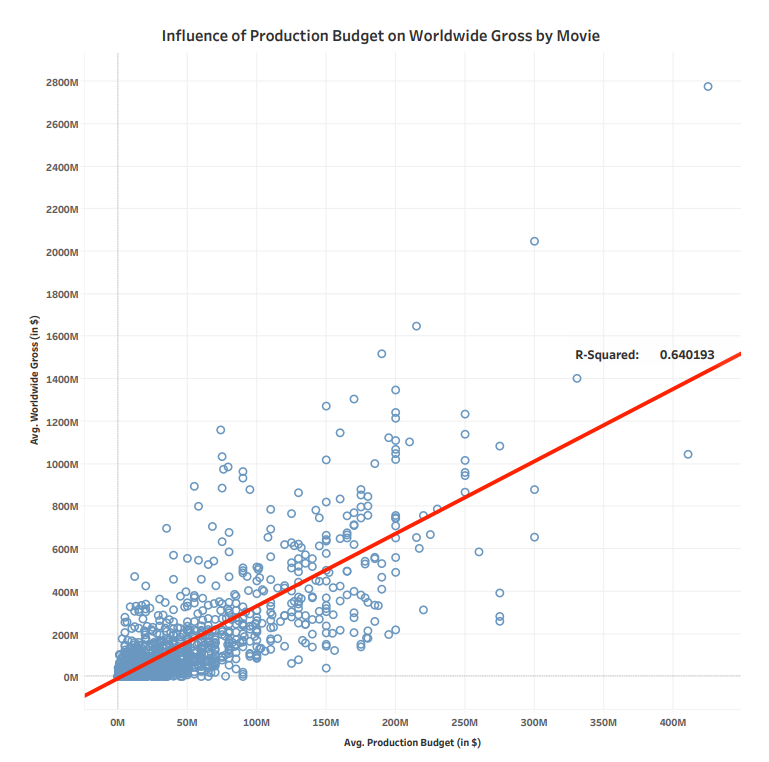

In the graph below, Musical, Animation, and Adventure are the top three genres by average worldwide gross.

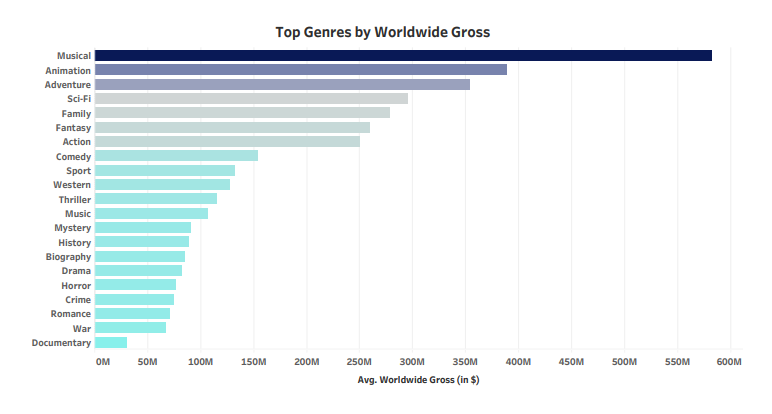

In the graph below, Christopher Nolan, Nuri Bilge Ceylan, and Damien Chazelle are the top three directors by average director rating in the Western market. S.S. Rajamouli, Neeraj Pandey, and Anurag Kashyap are the top three directors by average director rating in the Indian market.

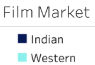

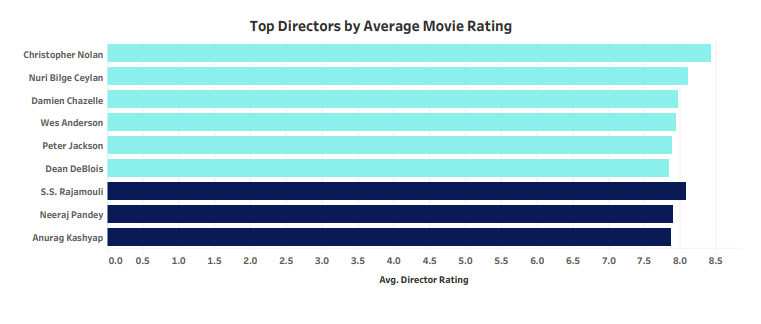

In order to confirm the importance of having a skilled director, we also ran an analysis on the influence of production on worldwide gross by director. 

H0: The amount of production budget that a director has available, does not impact the worldwide gross. <br>
HA: The amount of production budget that a director has available, impacts the worldwide gross.

The linear regression in Tableau returned the following results:<br>
P-value: < 0.0001<br>
Equation: Avg. Worldwide Gross = 4.30593*Avg. Production Budget + -1.88531e+07<br>

Coefficients<br>
Term Value StdErr t-value p-value<br>
Avg. Production Budget 4.30593 0.248112 17.3548 < 0.0001<br>
intercept -1.88531e+07 2.39984e+07 -0.785598 0.434832<br>

With a p value less than 0.0001, we can reject the null hypothesis and say that the amount of production budget that a director has available does impact the worldwide gross.

The graph below has an R-Squared value of .81, meaning the average production budget per director explains 81% of the variance in their worldwide gross.

Furthermore, our Trend Line equation breaks down to $4.31 in Worldwide Gross for every dollar spent in Production Budget.

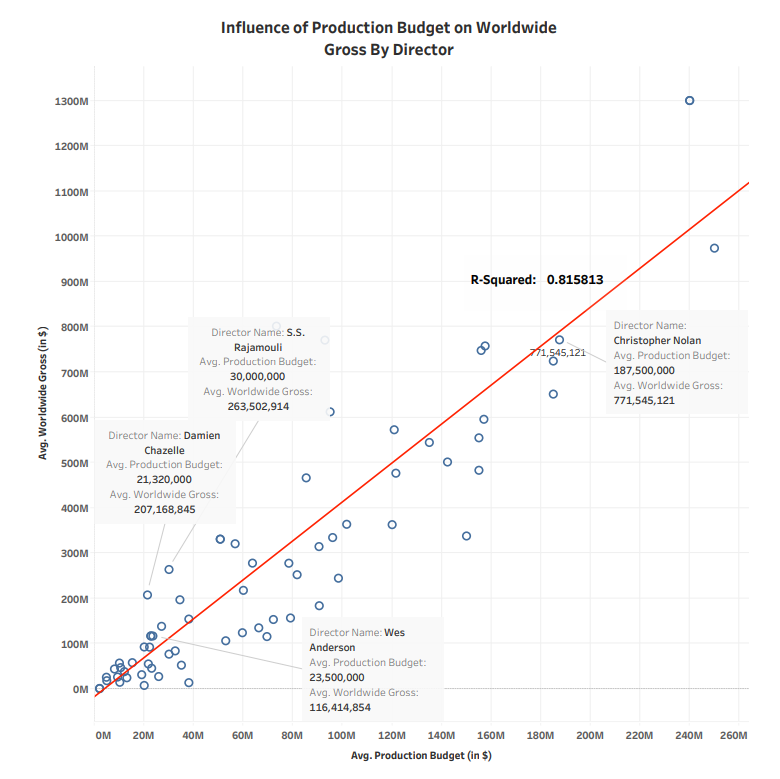

## Recommendations

### Budget

For budget, our recommendation is that you have to spend money to make money. As we can see in our linear regression graph, our data suggests that the bigger the budget, the bigger the return. Furthermore the R^2 value suggests that the budget accounts for 63% of variance in worldwide gross. This, along with a p-value smaller than .05 from the anova, shows that we can reject the null hypothesis and say that a film's budget does impact it's worldwide gross.

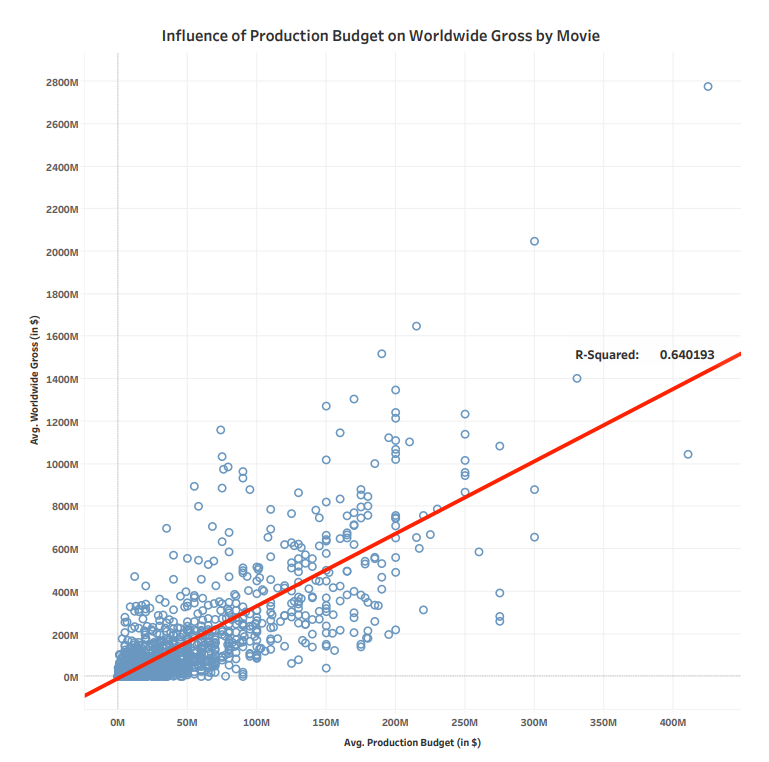

### Genre

For genre, we split movies out into each category they fell into and plotted the average worldwide gross by genre. Based on the graph below, we recommend creating adventurous, musical animations. These three genres had the highest average worldwide gross in our data and can easily pair well together in a film, as Olaf has proved.


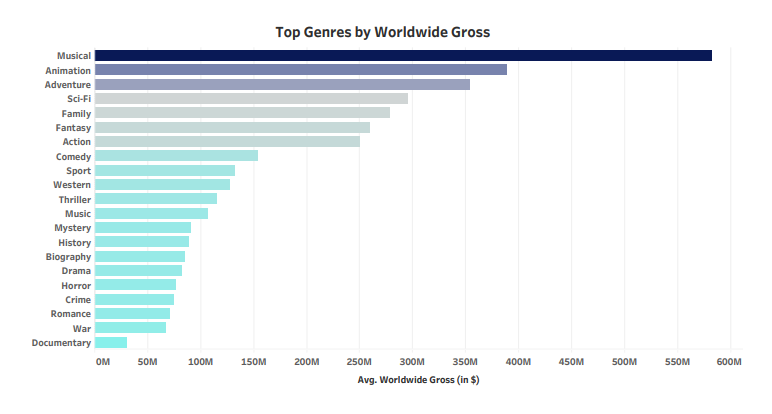

### Director

For director, we created a director rating by averaging all of the IMDb movie ratings for each director. From there we joined this data with the worldwide gross data to see which directors acquired the most gross across the globe. Directors have fans, and if you want to start building a brand, why not start with a director who has a large population already on board? 

This graph represents the best available Directors who also are Writers for the films they make based on the director rating score we calculated. For Western-Centric audiences, we recommend Christopher Nolan, Damien Chazelle, or Wes Anderson. Nuri Bilge Ceylan did not have any data regarding budget and gross, so we do not feel comfortable selecting him. For the Indian Film market, S.S. Rajamouli would be an excellent selection as Director. Neeraj Pandey and Anurag Kashyap did not have any data regarding budget and gross, so we do not feel comfortable selecting them.

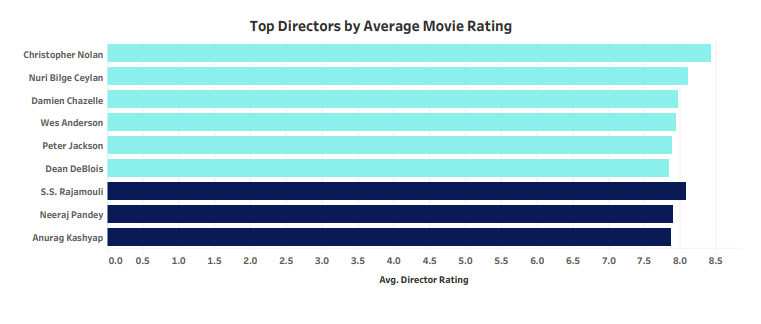

## Next Steps

Based on the project findings, there are several potential next steps to further enhance the analysis of film success. These steps include:

Genre Investigation: To enhance marketability, we would like to further investigate why these three genres (adventure, musical, and animation) are so successful. We hypothesize it may be because they are so accessible to all age ranges, but with more data we would be able to get a clearer picture. If we're able to glean more information as to the why, we would be able to better customize our ads for the demographics we have and the demographics we don't yet have but could be an opportunity. 

Release Date Investigation: Our analysis with this data found no correlation between a film's release date and its worldwide gross. However, we would like to dive deeper into this and see if certain genres have a correlation with worldwide gross based on their release date. If so, strategically timing movie premieres could make blockbuster films even more successful.

Worldwide Gross vs. Director Rating Investigation: While our statistical analysis of director rating and worldwide gross produced a low R^2 value, we think it would be beneficial to further investigate this correlation. Knowing how a director rating influences worldwide gross could help guide hiring decisions in the future. 

By pursuing these next steps, the analysis of film success could be strengthened, enabling more informed decision-making for AirFlix Studios in the film industry.

## Thank You!

Thank you for taking the time to review our recommendations. <br>
We hope this information helps and we look forward to working with you more on the next steps.

Sincerely, <br>
Bobby Daly, Michael Romanski <br>
Airflix Studios